In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import torch
import torchvision
import numpy as np
from torch.distributions.multivariate_normal import MultivariateNormal
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Load data

In [4]:
train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
val_data = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())

# Generate with underlying distribution directly

In [7]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=len(train_data))
x, y = next(iter(train_loader))

In [8]:
h, w = x.shape[2], x.shape[3]
dists = []

eps = 1e-4  # incase var = 0
means = torch.zeros(len(train_data.classes), h, w)
vars = torch.ones(len(train_data.classes), h, w) * eps

for digit in range(len(train_data.classes)):
    subset = x[torch.where(y == digit)[0], :, :]
    means[digit, :, :] = torch.mean(subset, dim=0).squeeze(0)
    vars[digit, :, :] += torch.var(subset, dim=0).squeeze(0)
    dists.append(MultivariateNormal(means[digit, :, :].reshape(-1).to(device),
                                    torch.diag(vars[digit, :, :].reshape(-1).to(device))))

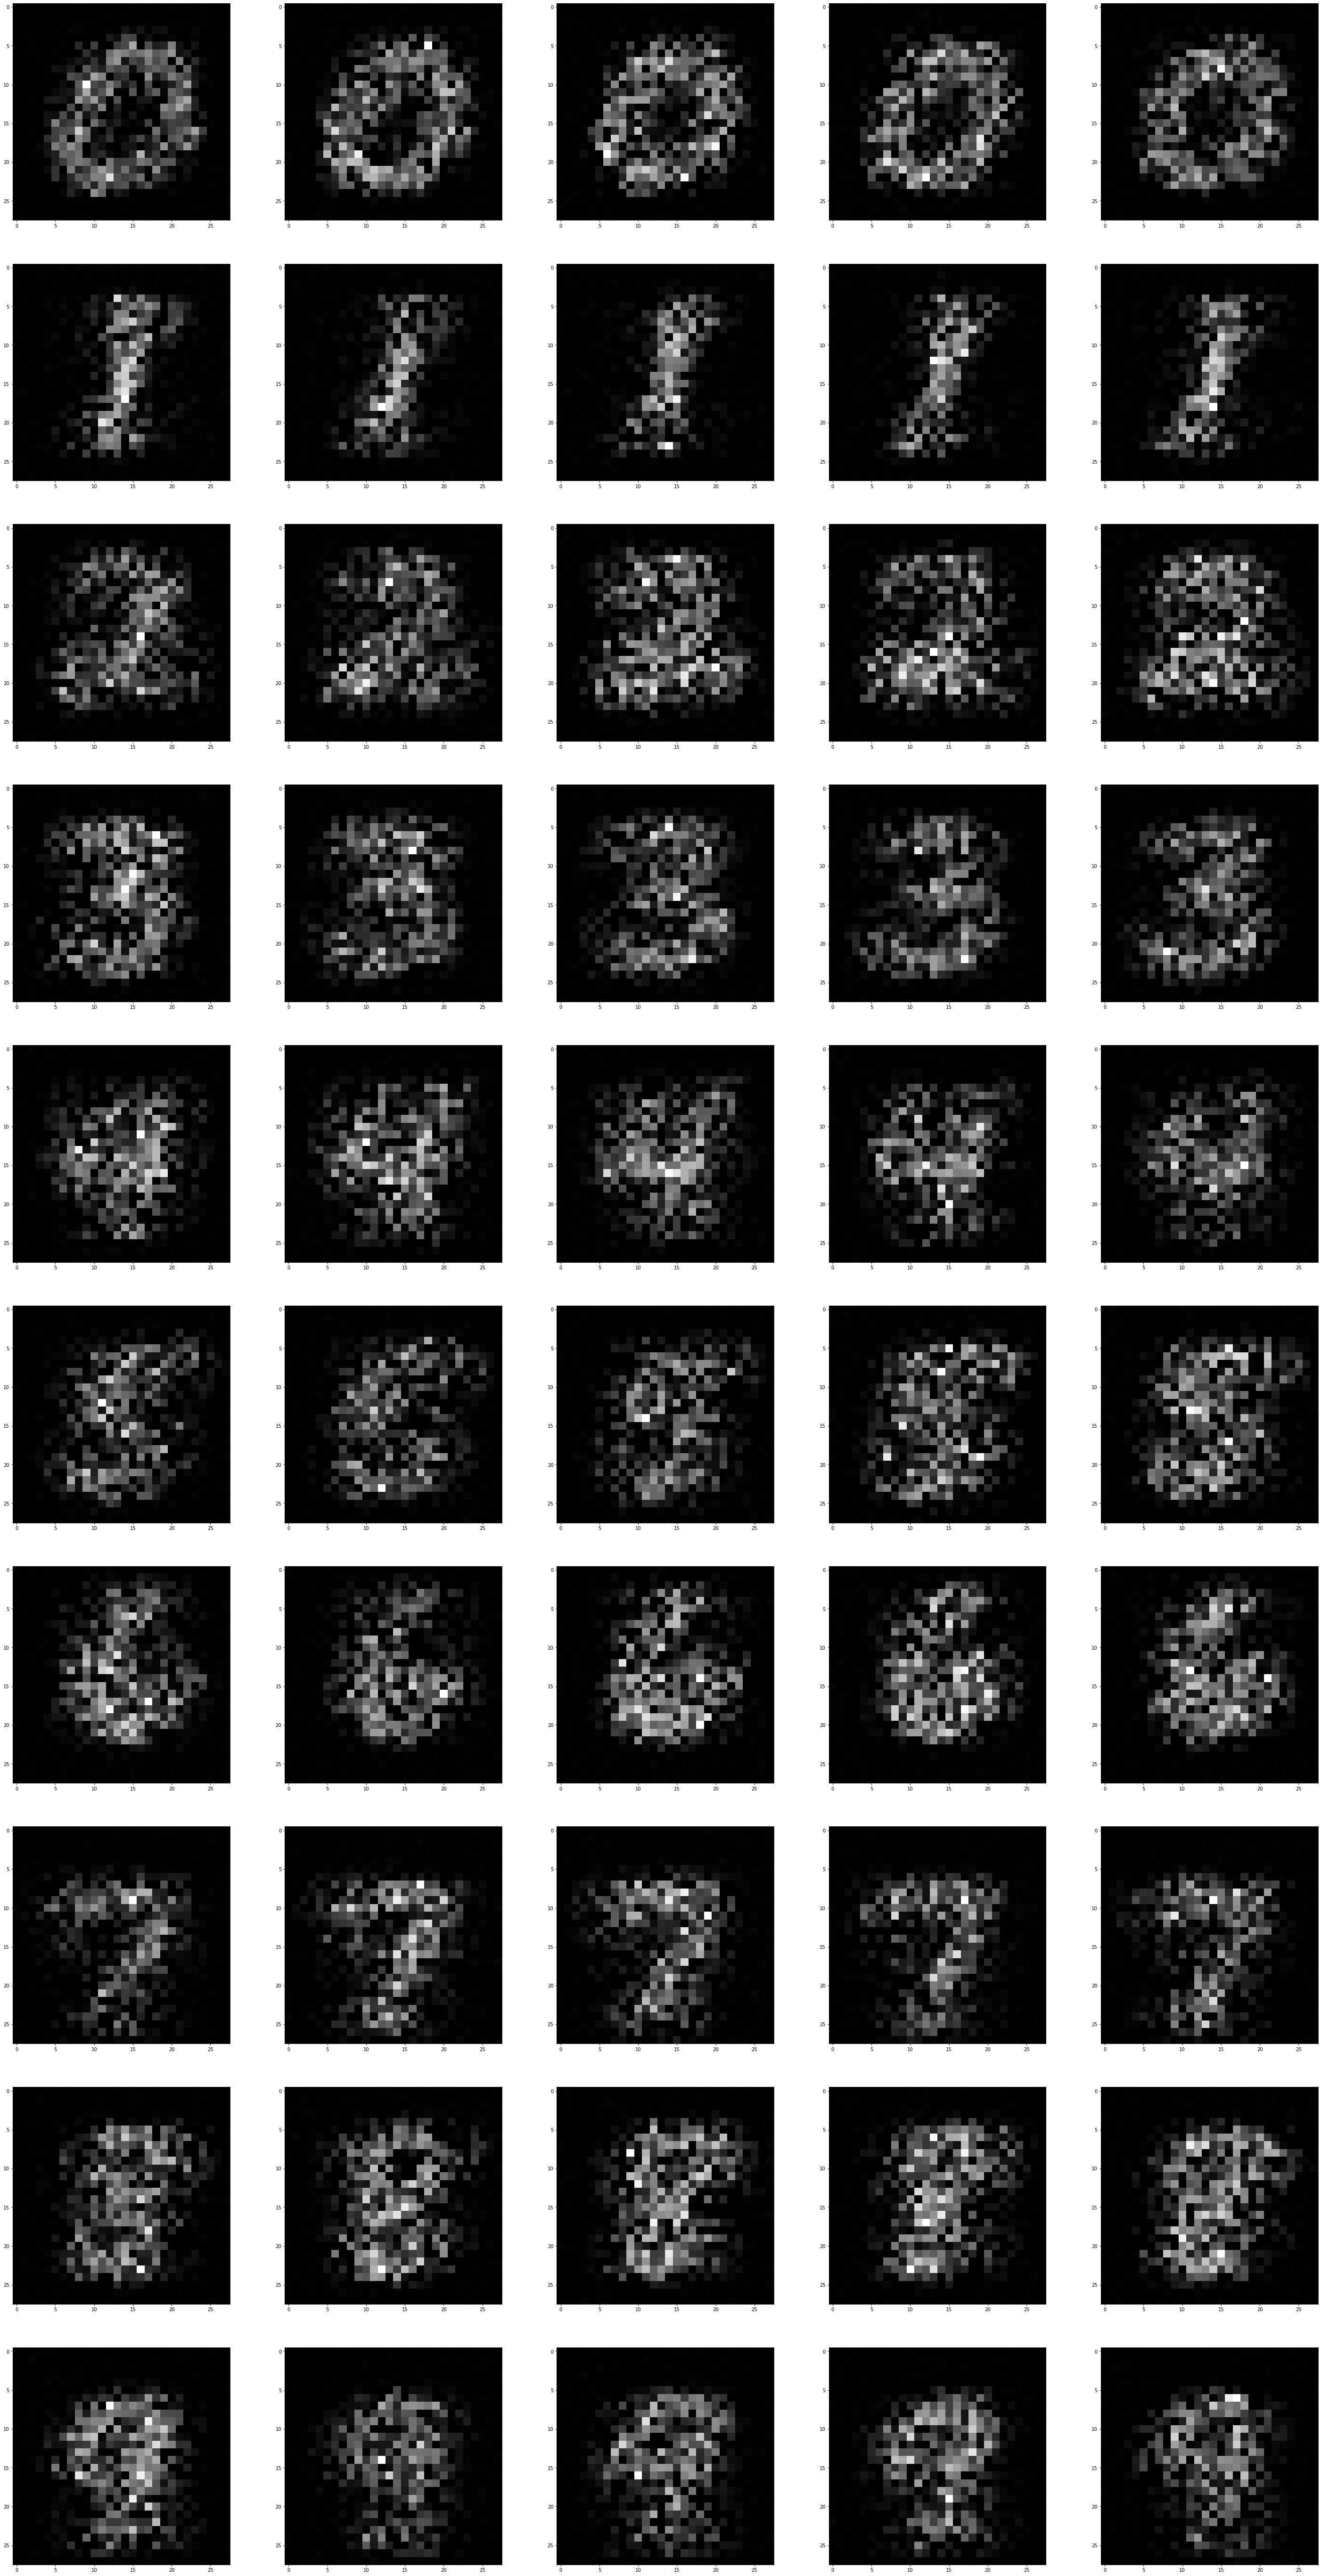

In [41]:
num_per_class = 5

fig=plt.figure(figsize=(50,100))

for d in range(10):
    imgs = dists[d].sample(torch.Size([num_per_class])).reshape(-1, h, w).cpu().numpy()
    imgs[imgs < 0] = 0
    for i in range(num_per_class):
        # img = torchvision.transforms.ToPILImage()(imgs[i, :, :])
        fig.add_subplot(10, num_per_class, d * num_per_class + i + 1)
        plt.imshow(imgs[i, :, :], cmap='gray')

# Reset dataloader

In [9]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)

# Try NF with unit Gaussian as base distribution here

In [10]:
from model import RealNVP

mask = np.arange(h * w / 2) * 2  # 0, 2, 4, ...
base_dist = MultivariateNormal(torch.zeros(28 * 28).to(device),
                               torch.eye(28 * 28).to(device))
model = RealNVP(mask, base_dist).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#TODO: seems log(p_x) and log_det_inv_j would be large negative number. e.g. -1e04

In [ ]:
epochs = 20
print_every = 1

for epoch in range(epochs):
    total_loss = 0
    for data in train_loader:
        x, _ = data
        x = x.to(device)
        optimizer.zero_grad()
        loss = - torch.sum(model.log_prob(x)) / x.shape[0]
        loss.backward()
        optimizer.step()
        total_loss += loss
        # print(loss)
    total_loss /= len(train_loader)

    if epoch % print_every == 0:
        print(f"Epoch {epoch} -> loss: {total_loss.item():.2f}")